<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Image_classification_basic_machine_learning_workflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classify images of flowers using a `keras.Sequential model`, and loads data using `preprocessing.image_dataset_from_directory`.

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

## basic machine learning workflow:

* Examine and understand data
* Build an input pipeline
* Build the model
* Train the model
* Test the model
* Improve the model and repeat the process

In [2]:
import tensorflow as tf
import os
import PIL
import pathlib
import matplotlib.pyplot as plt

## Download and explore the dataset
This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

<br>
flower_photo/<br>
  daisy/<br>
  dandelion/<br>
  roses/<br>
  sunflowers/<br>
  tulips/<br>
<br>

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

dataset = tf.keras.utils.get_file(fname='flowers', origin=dataset_url, untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [6]:
data_dir = pathlib.Path(dataset).parent
                      
for item in data_dir.iterdir():
  print(item)

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flowers.tar.gz


In [7]:
flowers_data = data_dir/'flower_photos'
for item in flowers_data.iterdir():
  print(item)

/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/tulips


In [11]:
# image count

image_count = len(list(flowers_data.glob('*/*.jpg')))
print('Total number of flower images',image_count)

Total number of flower images 3670


**Load using keras.preprocessing**

Let's load these images off disk using the helpful `image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset`. 

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

## Create a dataset


In [13]:
# Define some parameters for the loader:

seed = 42
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=flowers_data,
                                                               batch_size=batch_size,
                                                               image_size=(img_width, img_height),
                                                               seed=seed,
                                                               validation_split=0.2,
                                                               subset='training' )


val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=flowers_data,
                                                               batch_size=batch_size,
                                                               image_size=(img_width, img_height),
                                                               seed=seed,
                                                               validation_split=0.2,
                                                               subset='validation' )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
# classnames
print('Class names ',train_ds.class_names)

Class names  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Visualize the data
Here are the first 9 images from the training dataset.

In [16]:
image_batch , label_batch = next(iter(train_ds))

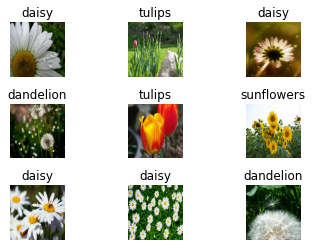

In [20]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  plt.title(train_ds.class_names[label_batch[i]])
  plt.axis('off')
  plt.subplots_adjust(hspace=0.5)
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [21]:
print('shape of image batch', image_batch.shape)
print('shape of label batch', label_batch.shape)

shape of image batch (32, 180, 180, 3)
shape of label batch (32,)


**Configure the dataset for performance**

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
def config_for_performance(ds, shuffle=False):
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(1000)
  ds = ds. prefetch(tf.data.AUTOTUNE)
  return ds

In [24]:
train_ds = config_for_performance(train_ds, shuffle=True)
val_ds = config_for_performance(val_ds)

**Standardize the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [25]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

## Create the model
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. 

In [26]:
num_classes = 5

In [31]:
model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
                             tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(num_classes)
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 101s 1s/step - loss: 1.4804 - accuracy: 0.3818 - val_loss: 1.2375 - val_accuracy: 0.5123
Epoch 2/10
92/92 [==============================] - 94s 1s/step - loss: 1.1184 - accuracy: 0.5637 - val_loss: 1.1204 - val_accuracy: 0.5586
Epoch 3/10
92/92 [==============================] - 93s 1s/step - loss: 0.9142 - accuracy: 0.6516 - val_loss: 1.0122 - val_accuracy: 0.5872
Epoch 4/10
92/92 [==============================] - 94s 1s/step - loss: 0.6989 - accuracy: 0.7343 - val_loss: 1.0051 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 94s 1s/step - loss: 0.4761 - accuracy: 0.8249 - val_loss: 1.2420 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 94s 1s/step - loss: 0.3268 - accuracy: 0.8903 - val_loss: 1.4189 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 94s 1s/step - loss: 0.1718 - accuracy: 0.9455 - val_loss: 1.6104 - val_accuracy: 0.6376
Epoch 8/10
92/92 [=

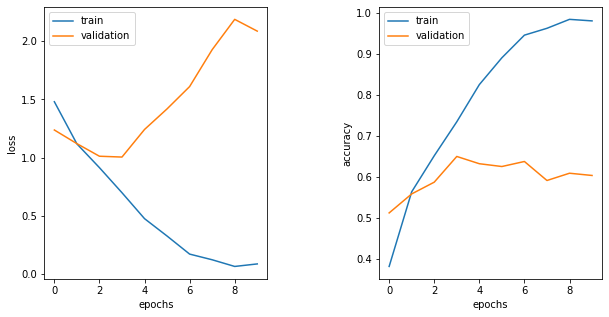

In [43]:
index = 0
plt.figure(figsize=(10,5))
for metric in ['loss', 'accuracy']:
  index += 1
  plt.subplot(1,2,index)
  plt.plot(range(10), history.history[metric])
  plt.plot(range(10), history.history['val_'+metric])
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.subplots_adjust(wspace=0.5)
  plt.legend(['train', 'validation'])


As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

**Overfitting**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting 
* data augmentation
* add Dropout to your model

**Data augmentation**
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [46]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape=(img_width,img_height,3)),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
                                         

])

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

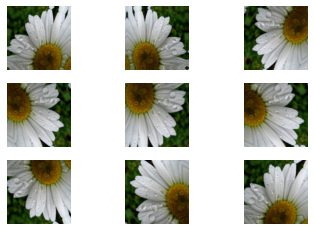

In [56]:
for i in range(9):
  aug_img = data_augmentation(image_batch)
  plt.subplot(3,3,i+1)
  plt.imshow(aug_img[0].numpy().astype('uint8'))
  plt.axis('off')
plt.show()

**Dropout**

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [58]:
model = tf.keras.Sequential([
                             data_augmentation,
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                             tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(num_classes)                                                         
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [60]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
92/92 [==============================] - 109s 1s/step - loss: 1.3087 - accuracy: 0.4223 - val_loss: 1.1259 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 108s 1s/step - loss: 1.0591 - accuracy: 0.5647 - val_loss: 1.0823 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 108s 1s/step - loss: 0.9855 - accuracy: 0.6063 - val_loss: 0.9568 - val_accuracy: 0.6335
Epoch 4/15
92/92 [==============================] - 108s 1s/step - loss: 0.9183 - accuracy: 0.6410 - val_loss: 0.9341 - val_accuracy: 0.6117
Epoch 5/15
92/92 [==============================] - 109s 1s/step - loss: 0.8804 - accuracy: 0.6512 - val_loss: 0.8429 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 109s 1s/step - loss: 0.8210 - accuracy: 0.6836 - val_loss: 0.8798 - val_accuracy: 0.6853
Epoch 7/15
92/92 [==============================] - 108s 1s/step - loss: 0.7960 - accuracy: 0.6846 - val_loss: 0.8783 - val_accuracy: 0.6757
Epoch 8/15
92

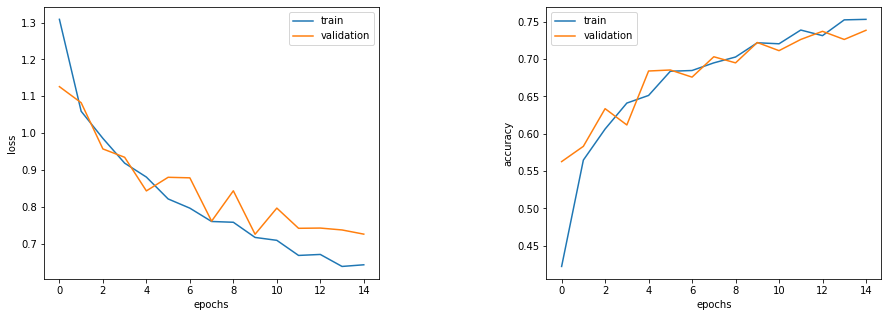

In [63]:
index = 0
plt.figure(figsize=(15,5))
for metric in ['loss', 'accuracy']:
  index += 1
  plt.subplot(1,2,index)
  plt.plot(range(15), history.history[metric])
  plt.plot(range(15), history.history['val_'+metric])
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.subplots_adjust(wspace=0.5)
  plt.legend(['train', 'validation'])


## Predict on new data
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [64]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"

In [65]:
sunflower_path = tf.keras.utils.get_file(fname='sunflower', origin=sunflower_url)

122880/117948 [===============================] - 0s 0us/step


In [83]:
print('path to image file :',sunflower_path)

path to image file : /root/.keras/datasets/sunflower


In [84]:
# Loads an image into PIL format.
# ImportError	if PIL is not available.
# ValueError	if interpolation method is not supported.

sunflower_image = tf.keras.preprocessing.image.load_img(path=sunflower_path, target_size=(img_height,img_width))

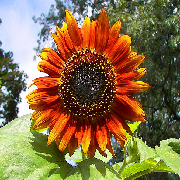

In [86]:
sunflower_image

In [87]:
# Converts a PIL Image instance to a Numpy array.
sunflower_images_array = tf.keras.preprocessing.image.img_to_array(sunflower_image)

In [90]:
# shape of image
print('Shape of image',sunflower_images_array.shape)
# Convert single image to a batch.
sunflower_image_batch = tf.expand_dims(sunflower_images_array, 0)
print('Shape of image batch',sunflower_image_batch.shape)

Shape of image (180, 180, 3)
Shape of image batch (1, 180, 180, 3)


In [91]:
prediction = model.predict(sunflower_image_batch)

In [115]:
score = tf.nn.softmax(prediction[0])

In [116]:
class_index = tf.argmax(score)

In [118]:
 class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print('Prediction made by model say image belong to class {} with confidence {}'.format(class_names[class_index], score[class_index]))

Prediction made by model say image belong to class sunflowers with confidence 0.9950594902038574
